# Load data, define model

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# Set parameters

In [ ]:
exp = 'Final_B0correction_In_Brain' # must be available in the models folder

#### Define data folder ####

subject = 'Vol1_London_B0corrected_wo_LipidMask' # must exist inside data folder

# Load data and masks

In [3]:
#Define parameters 

#### Load data and brain mask ####

data = np.load('../data/'+subject+'/OriginalData/data.npy')

spectra = np.fft.fftshift(np.fft.fft(data, axis=-1), axes=-1)

# load brain mask:
brainmask = np.load('../data/'+subject+'/masks/brain_mask.npy')

#### Load lipid mask ####
skmask = np.load('../data/'+subject+'/masks/lipid_mask.npy')

# transpose to match naiming conventions of bernis pipeline
# spectra = spectra.transpose(1,0,2,3)
# brainmask = brainmask.transpose(1,0,2)
# skmask = skmask.transpose(1,0,2)

headmask = brainmask + skmask 

In [4]:
import os
import sys

model_dir = os.path.abspath(f'../models/{exp}')
src_dir   = os.path.abspath(f'../src')

sys.path.insert(0, model_dir)
sys.path.insert(0, src_dir)
#pip install h5py nibabel pandas glob2 regex

import numpy as np
import nibabel as nib
import h5py
import time
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn
os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work
import scipy.io as sio
from lipidRemoval import *

# compute lipid projection / lipid removal operator

In [5]:
import numpy as np

# ------------------------------------------------------------------
# 1)  Daten vorbereiten  
T        = spectra.shape[-1]                 # 960
Data_rf  = spectra.reshape(-1, T)            # (Nvox, 960)
lipid_rf = Data_rf[skmask.flatten() > 0, :]  # scalp-Voxels

#2)  β bestimmen und Operatoren berechnen
beta, M = find_beta_bisect(lipid_rf)          # garantiert konvergent
RemOP   = np.linalg.inv(np.eye(T) + beta * M)
LipidRem_Operator_ff  = RemOP
LipidProj_Operator_ff = np.eye(T) - RemOP

print(f"Achieved diag-mean = {np.mean(np.abs(np.diag(RemOP))):.4f} at β = {beta:.2e}")


Achieved diag-mean = 0.9417 at β = 6.55e-06


In [6]:
# ——————————— Example usage ———————————
if __name__ == "__main__":
    # 1) Prepare device & experiment name
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 4) Run lipid removal
    Data_LipidRemoved_rrrf = runNNLipRemoval2(
        device,
        exp,
        spectra,
        LipidProj_Operator_ff,
        headmask,
        batch_size=200
    )

[runNNLipRemoval2] done in 28.5s


In [7]:
Nuisance_Free_FID_Data = np.fft.ifft(np.fft.ifftshift(Data_LipidRemoved_rrrf, axes=-1), axis=-1) # go back to FID domain
np.save(f'data_after_walinet.npy',Nuisance_Free_FID_Data)

np.save(f'../data/{subject}/OriginalData/data_after_walinet.npy',Nuisance_Free_FID_Data)

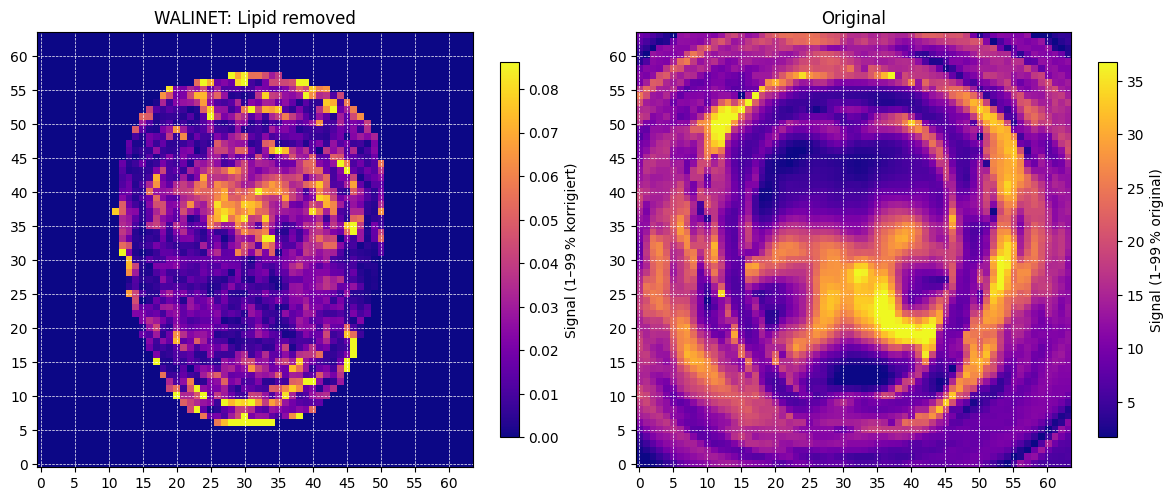

In [8]:
import numpy as np
import matplotlib.pyplot as plt

z, t = 20, 420

# Slice extrahieren
Slice_corrected = np.abs(Data_LipidRemoved_rrrf)[:, :, z, t]
Slice_original = np.abs(spectra)[:, :, z, t]

# Perzentile separat berechnen
vmin_corr = np.percentile(Slice_corrected, 1)
vmax_corr = np.percentile(Slice_corrected, 99)
vmin_orig = np.percentile(Slice_original, 1)
vmax_orig = np.percentile(Slice_original, 99)

# Plot mit zwei Subplots nebeneinander
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Plot: WALINET
im1 = axes[0].imshow(Slice_corrected, cmap="plasma", origin="lower",
                     vmin=vmin_corr, vmax=vmax_corr)
axes[0].set_title("WALINET: Lipid removed")
axes[0].grid(visible=True, color='white', linestyle='--', linewidth=0.5)
axes[0].set_xticks(np.arange(0, Slice_corrected.shape[1], 5))
axes[0].set_yticks(np.arange(0, Slice_corrected.shape[0], 5))
cbar1 = fig.colorbar(im1, ax=axes[0], shrink=0.8)
cbar1.set_label("Signal (1–99 % korrigiert)")

# 2. Plot: Original
im2 = axes[1].imshow(Slice_original, cmap="plasma", origin="lower",
                     vmin=vmin_orig, vmax=vmax_orig)
axes[1].set_title("Original")
axes[1].grid(visible=True, color='white', linestyle='--', linewidth=0.5)
axes[1].set_xticks(np.arange(0, Slice_original.shape[1], 5))
axes[1].set_yticks(np.arange(0, Slice_original.shape[0], 5))
cbar2 = fig.colorbar(im2, ax=axes[1], shrink=0.8)
cbar2.set_label("Signal (1–99 % original)")

plt.tight_layout()
plt.show()



In [9]:
# -*- coding: utf-8 -*-
"""Pipeline zum Vergleichen beliebiger Subjects & WALINET-Varianten.

  • Vorbereitung & Caching (complex Spectra bleiben komplex!)
  • Flexible Plot-Funktion mit freiem Frequenzbereich & gemeinsamer Skala

Wichtig: *Nur* `proj_ff` wird als **real** gespeichert (theoretisch rein reell).
Die **Spectra** selbst bleiben complex64 – erst bei `prepare_case()` wird für
das Plotten |…| gebildet.
"""

from __future__ import annotations

import numpy as np
from pathlib import Path
from functools import lru_cache
import torch
import matplotlib.pyplot as plt

from lipidRemoval import find_beta_bisect, runNNLipRemoval2

DATA_ROOT = Path("../data")
MODEL_ROOT = Path("../models")

# ---------------------------------------------------- Laden & Caching
@lru_cache(maxsize=None)
def _load_subject(subject: str):
    subj_dir = DATA_ROOT / subject
    data = np.load(subj_dir / "OriginalData" / "data.npy")            # complex FID

    spectra = np.fft.fftshift(np.fft.fft(data, axis=-1), axes=-1)
    spectra = spectra.astype(np.complex64)                               # <-- complex behalten

    brainmask = np.load(subj_dir / "masks" / "brain_mask.npy")
    skmask = np.load(subj_dir / "masks" / "lipid_mask.npy")
    headmask = brainmask + skmask

    # Lipid-Projektor – sollte *real* sein. winzige imag‑Teile → weg.
    T = spectra.shape[-1]
    lipid_rf = spectra.reshape(-1, T)[skmask.flatten() > 0]
    beta, M = find_beta_bisect(lipid_rf)
    RemOP = np.linalg.inv(np.eye(T) + beta * M)
    proj_ff = np.asarray(RemOP.real, dtype=np.float32)                   # real32 → kein Warning

    return dict(spectra=spectra, headmask=headmask, proj_ff=proj_ff)

# ---------------------------------------------------- Preparation API
_prepare_case_cache: dict[tuple[str, str | None], np.ndarray] = {}

def prepare_case(subject: str, walinet_exp: str | None = None) -> np.ndarray:
    key = (subject, walinet_exp)
    if key in _prepare_case_cache:
        return _prepare_case_cache[key]

    subj = _load_subject(subject)

    if walinet_exp is None:
        arr = np.abs(subj["spectra"])           # Original-Magnitude
    else:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        arr = runNNLipRemoval2(device,
                               walinet_exp,
                               subj["spectra"],
                               subj["proj_ff"],
                               subj["headmask"],
                               batch_size=200)
        arr = np.abs(arr)

    _prepare_case_cache[key] = arr
    return arr

def prepare_cases(cases):
    data_list, labels = [], []
    for subj, exp, lbl in cases:
        print(f"⌛  prepare_case(subject='{subj}', model='{exp}') …")
        data_list.append(prepare_case(subj, exp))
        labels.append(lbl)
    return data_list, labels

# ---------------------------------------------------- Plotting

def plot_row_spectra(
    data_list, labels, *,
    x, z, y_vals,
    freq_range=(0, 840),
    shared_scale_from=1,      # erste Spalte behält eigene Skala
    figsize_per_row=2.2,
):
    start, end = freq_range
    slice_abs = lambda arr: np.abs(arr[..., start:end + 1])

    n_rows = len(y_vals)
    n_cols = len(data_list)
    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, figsize_per_row * n_rows),
        sharex=True
    )
    axs = np.atleast_2d(axs)

    # -------- pro Zeile: gemeinsames y-Max für Spalten >= shared_scale_from
    shared_max_row = []
    for row, y in enumerate(y_vals):
        if n_cols > shared_scale_from:
            row_max = max(
                slice_abs(arr)[x, y, z, :].max()
                for arr in data_list[shared_scale_from:]
            )
        else:
            row_max = None
        shared_max_row.append(row_max)
    # --------------------------------------------------

    for col, (arr, title) in enumerate(zip(data_list, labels)):
        sub = slice_abs(arr)
        for row, y in enumerate(y_vals):
            axs[row, col].plot(sub[x, y, z, :])

            # Zeilen-spezifische gemeinsame Skala
            if col >= shared_scale_from and shared_max_row[row] is not None:
                axs[row, col].set_ylim(0, shared_max_row[row] * 1.05)

            # Y-Achse nur links
            if col == 0:
                axs[row, col].set_ylabel(f"Ampl.\n(y={y})", fontsize=7)
            else:
                axs[row, col].tick_params(axis="y", labelleft=False)

        axs[0, col].set_title(title)
        axs[-1, col].set_xlabel("Freq-Bin")

    plt.tight_layout()
    plt.show()



In [10]:
# CASES = [
#     ("Vol5", None,                     "Original B0"),
#     ("Vol5", "Vienna_5DataSets_1.1_deep","WALINET 5 datasets"),
#     ("Vol5",     "10DataSets_1.0",    "WALINET 10 datasets"),
# ]

# # ---- 1× rechenintensiv ----
# data_list, labels = prepare_cases(CASES)

In [11]:
# ---- beliebig oft plotten ----
plot_row_spectra(data_list, labels, 
                 x=20, z=17, y_vals=range(10, 60),
                 freq_range=(0, 840))     # voller Bereich

plot_row_spectra(data_list, labels,
                 x=20, z=17, y_vals=range(10, 60),
                 freq_range=(500, 840))   # nur hoher Teil

NameError: name 'data_list' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_row_spectra(
    data_list,               # list[np.ndarray]  –  (X, Y, Z, T)
    labels,                  # list[str]         –  Spaltentitel
    x=20,                    # feste x-Position
    z=17,                    # fester z-Slice
    y_vals=range(10, 60),    # iterable von y-Indizes
    figsize_per_row=2.2,     # Höhe pro Zeile (in inch)
    amp_abs=True             # |…| oder komplexe Werte zeichnen
):
    """Vergleicht mehrere 4-D Datensätze voxelweise (y-Zeilen) in Spalten."""
    
    assert len(data_list) == len(labels), "labels ≠ arrays"
    n_rows = len(y_vals)
    n_cols = len(data_list)

    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(4 * n_cols, figsize_per_row * n_rows),
        sharex=True
    )

    # Wenn nur 1 Zeile/Spalte, axs -> 2-D-Array erzwingen
    axs = np.atleast_2d(axs)

    for col, (data, title) in enumerate(zip(data_list, labels)):
        # Optionale |…|
        if amp_abs:
            data = np.abs(data)

        for row, y in enumerate(y_vals):
            axs[row, col].plot(data[x, y, z, :])
            
            # Y-Achsenbeschriftung nur in erster Spalte
            if col == 0:
                axs[row, col].set_ylabel(f"Ampl.\n(y={y})", fontsize=7)
                axs[row, col].tick_params(axis="y", labelsize=6)
            else:
                axs[row, col].tick_params(axis="y", labelleft=False)

        # Spaltentitel
        axs[0, col].set_title(title)

        # X-Achsenbeschriftung nur in letzter Zeile
        axs[-1, col].set_xlabel("Time (FID pt)")

    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------
# 1) Datensätze vorbereiten
Data_orig = np.abs(np.fft.fftshift(np.fft.fft(data, axis=-1), axes=-1))

# zwei WALINET-Varianten laufen lassen (nur Beispiel-Namen)
Data_LipidRemoved_v1 = np.abs(runNNLipRemoval2(
    device, "14Datasets_B0correction", spectra, LipidProj_Operator_ff,
    headmask, batch_size=200
))

Data_LipidRemoved_v2 = np.abs(runNNLipRemoval2(
    device, "10DataSets_1.0", spectra, LipidProj_Operator_ff,
    headmask, batch_size=200
))

# -----------------------------------------------------------
# 2) Plotten
plot_row_spectra(
    data_list=[Data_orig, Data_LipidRemoved_v1, Data_LipidRemoved_v2],
    labels   =["Original", "WALINET B0 corrected", "WALINET no B0 correction"],
    x=20,
    z=17,
    y_vals=range(10, 60)   # oder z. B. list(range(10, 50, 2))
)
